In [2]:
import matplotlib.pyplot as plt
import sys
import numpy as np
from transformers import (MBartForConditionalGeneration, MBart50TokenizerFast,
						M2M100ForConditionalGeneration, M2M100Tokenizer,
						AutoTokenizer, AutoModelForSeq2SeqLM,
						AutoModelForCausalLM, MT5ForConditionalGeneration,
						Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, Seq2SeqTrainer)

/home/sergio/miniconda3/envs/fake/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def load_tokenizer(name, src, tgt):
	if name == 'mbart':
		_tok = MBart50TokenizerFast.from_pretrained('facebook/mbart-large-50-many-to-many-mmt')
	elif name == 'm2m':
		_tok = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")
	elif name == 'flant5':
		_tok = AutoTokenizer.from_pretrained("google/flan-t5-base")
	elif name == 'mt5':
		_tok = AutoTokenizer.from_pretrained("google/mt5-small")
	elif name == 'nllb':
		_tok = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
	else:
		print('Model not implemented: {0}'.format(name))
		sys.exit(1)
	_tok.src_lang = src
	_tok.tgt_lang = tgt
	return _tok

def load_data(src,tgt):
    '''
        Loads a dataset

        :param dataset_name: Name of the dataset to load
        :param src: Source language
        :param tgt: Target language
        :param return_labels: Whether to return formality labels. Only implemented for cocoa dataset
    '''
    root = '/home/sergio/FAKE/europarl-inmt'
    root += f'/{src}-{tgt}' if src != 'en' else f'/{tgt}-{src}'
    with open(root + f'/test.{src}', 'r') as f:
        source = f.readlines()
    with open(root + f'/test.{tgt}', 'r') as f:
        target = f.readlines()
    return source, target

def count_unks(sentence, tokenizer):
	tokens = tokenizer(sentence, return_tensors='pt')
	return tokens['input_ids'].eq(tokenizer.unk_token_id).sum().item() / tokens['input_ids'].shape[1]

def count_total_unk(data, tokenizer):
	return np.mean(np.array([count_unks(sent, tokenizer) for sent in data]))

In [ ]:
XTICKS = [('fr','en'),('en','fr'),('es','en'),('en','es'),('de','en'),('en','de')]
num_series = 6
BAR_WIDTH = 0.15
mbart = [count_total_unk(load_data(src,tgt)[1], load_tokenizer('mbart',src,tgt))*100 for src,tgt in XTICKS]
m2m = [count_total_unk(load_data(src,tgt)[1], load_tokenizer('m2m',src,tgt))*100 for src,tgt in XTICKS]
flant5 = [count_total_unk(load_data(src,tgt)[1], load_tokenizer('flant5',src,tgt))*100 for src,tgt in XTICKS]
nllb = [count_total_unk(load_data(src,tgt)[1], load_tokenizer('nllb',src,tgt))*100 for src,tgt in XTICKS]

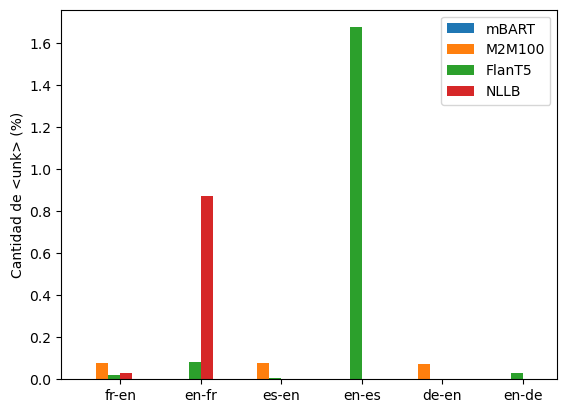

In [26]:
plt.figure()
plt.bar(np.arange(num_series)+BAR_WIDTH*0-(num_series-1)*BAR_WIDTH/2,mbart, BAR_WIDTH, label='mBART')
plt.bar(np.arange(num_series)+BAR_WIDTH*1-(num_series-1)*BAR_WIDTH/2,m2m, BAR_WIDTH, label='M2M100')
plt.bar(np.arange(num_series)+BAR_WIDTH*2-(num_series-1)*BAR_WIDTH/2,flant5, BAR_WIDTH, label='FlanT5')
plt.bar(np.arange(num_series)+BAR_WIDTH*3-(num_series-1)*BAR_WIDTH/2,nllb, BAR_WIDTH, label='NLLB')
plt.xticks(np.arange(num_series), [f'{src}-{tgt}' for src,tgt in XTICKS])
plt.ylabel('Cantidad de <unk> (%)')
plt.legend()
plt.show()

In [23]:
print('\t'.join([f'{src}-{tgt}' for src,tgt in XTICKS]))
for serie in [mbart,m2m,flant5,nllb]:
    print('\t'.join([f'{val:.4f}' for val in serie]))

fr-en	en-fr	es-en	en-es	de-en	en-de
0.0000	0.0000	0.0000	0.0000	0.0000	0.0000
0.0794	0.0000	0.0770	0.0000	0.0730	0.0000
0.0184	0.0825	0.0059	1.6764	0.0036	0.0296
0.0282	0.8716	0.0000	0.0000	0.0000	0.0000


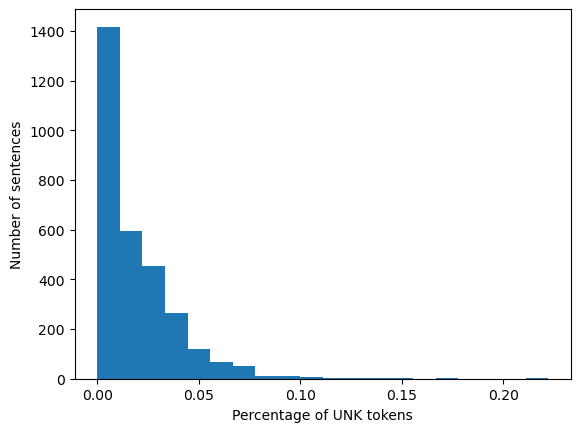

In [25]:
src = 'en'
tgt = 'es'

tok = load_tokenizer('flant5',src,tgt)
plt.figure()
plt.hist([count_unks(sent, tok) for sent in load_data(src,tgt)[1]], bins=20)
plt.xlabel('Percentage of UNK tokens')
plt.ylabel('Number of sentences')
plt.show()